In [48]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import pickle


In [24]:
def load_images_as_bw_matrices(directory):
    image_matrices = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        # Check if it's a valid file
        if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.JPG')):
            try:
                # Open the image
                with Image.open(filepath) as img:
                    # Convert to black and white
                    # bw_img = img.convert('L')
                    # Convert to a numpy array (matrix)
                    matrix = np.array(img)
                    # Append the matrix to the list
                    image_matrices.append(matrix)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    
    return image_matrices

In [25]:
# Display the nth image in the list
def show_image(image_matrices, n):
    if image_matrices:
        plt.imshow(image_matrices[n], cmap='gray')
        plt.title(f"Image {n}")
        plt.axis('off')  # Turn off axis labels
        plt.show()
    else:
        print("The list of image matrices is empty!")

In [26]:
# Example usage
clean = load_images_as_bw_matrices('data/train/clean')
dirty = load_images_as_bw_matrices('data/train/dirty')
combined = clean + dirty

# Output the number of processed images
print(f"Processed {len(clean)} images for clean plates")
print(f"Processed {len(dirty)} images for dirty plates")

Processed 291 images for clean plates
Processed 501 images for dirty plates


In [27]:
# Display all images in a grid, resized to small thumbnails
def show_some_images(image_matrices, max_cols=5, thumbnail_size=(64, 64), num=20):
    if not image_matrices:
        print("The list of image matrices is empty!")
        return

    if len(image_matrices) < num:
        num = len(image_matrices)

    images = image_matrices[:num]
    
    # Calculate grid dimensions
    num_images = len(images)
    rows = (num_images + max_cols - 1) // max_cols  # Ceiling division for rows
    
    # Create figure
    fig, axes = plt.subplots(rows, max_cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten to 1D for easy iteration

    for idx, matrix in enumerate(images):
        # Resize matrix for smaller display (optional)
        thumbnail = matrix[::matrix.shape[0] // thumbnail_size[0] or 1, ::matrix.shape[1] // thumbnail_size[1] or 1]
        
        axes[idx].imshow(thumbnail)
        axes[idx].axis('off')  # Turn off axis labels
    
    # Hide any unused axes
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

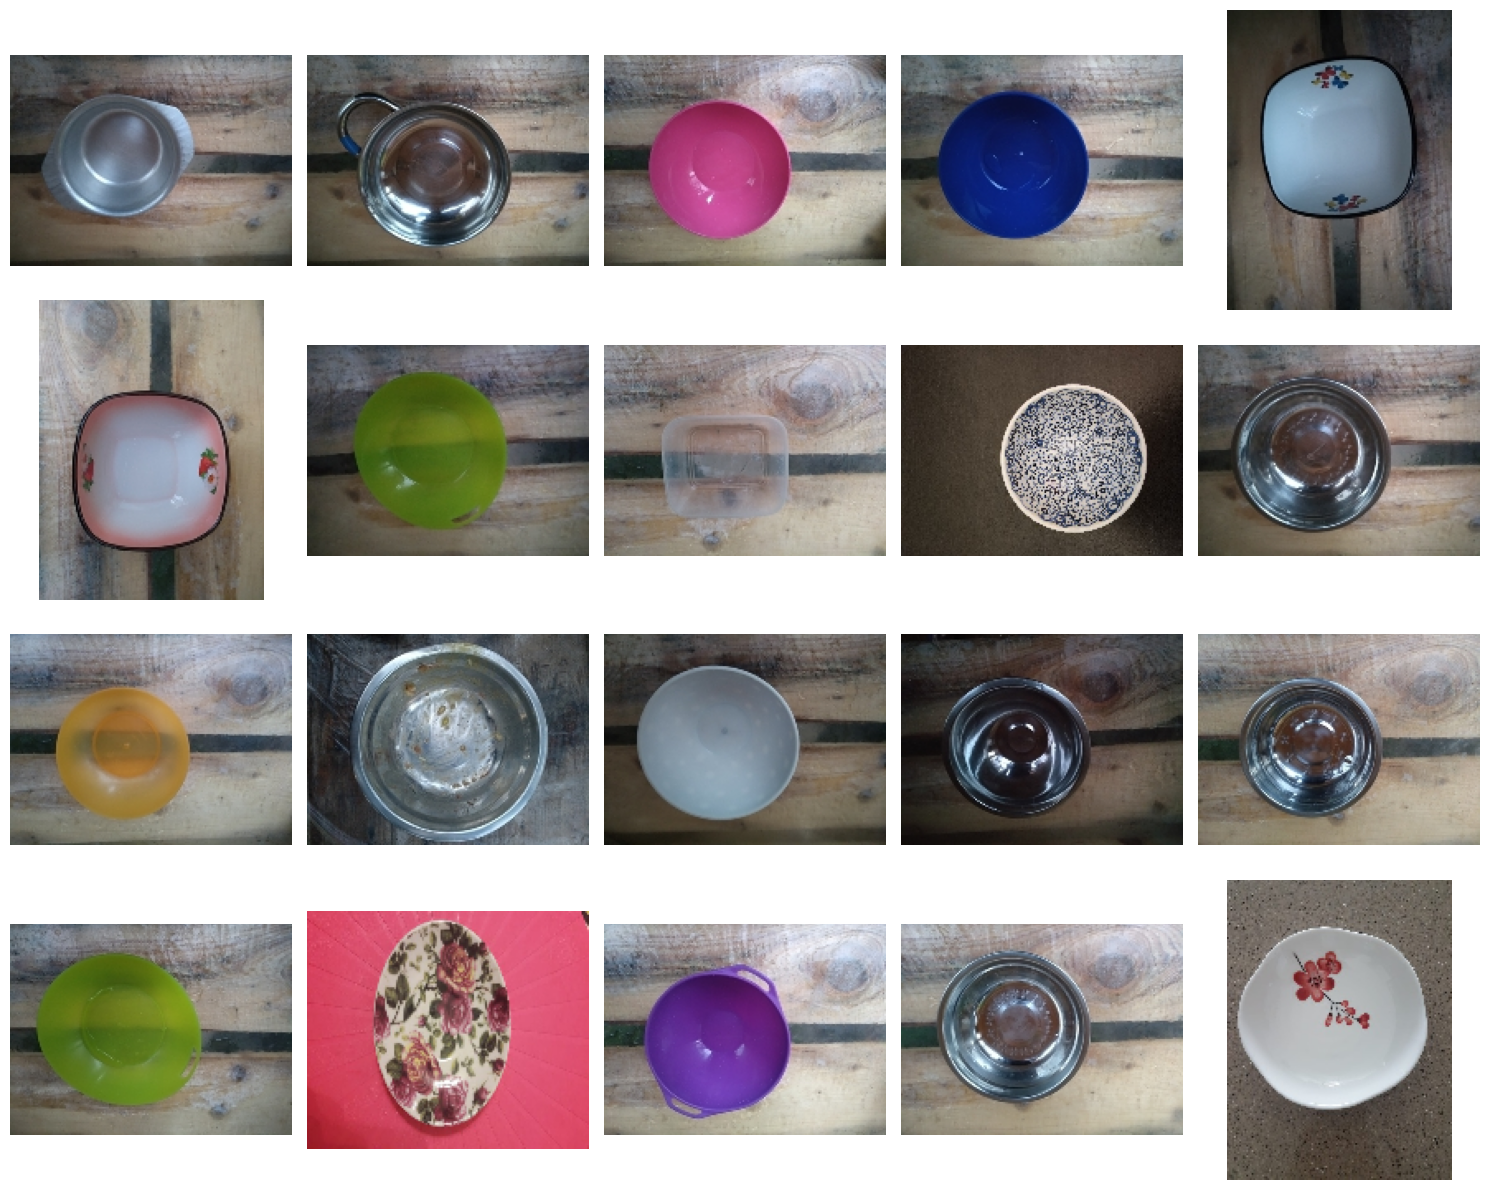

In [28]:
show_some_images(clean, max_cols=5, thumbnail_size=(128, 128))

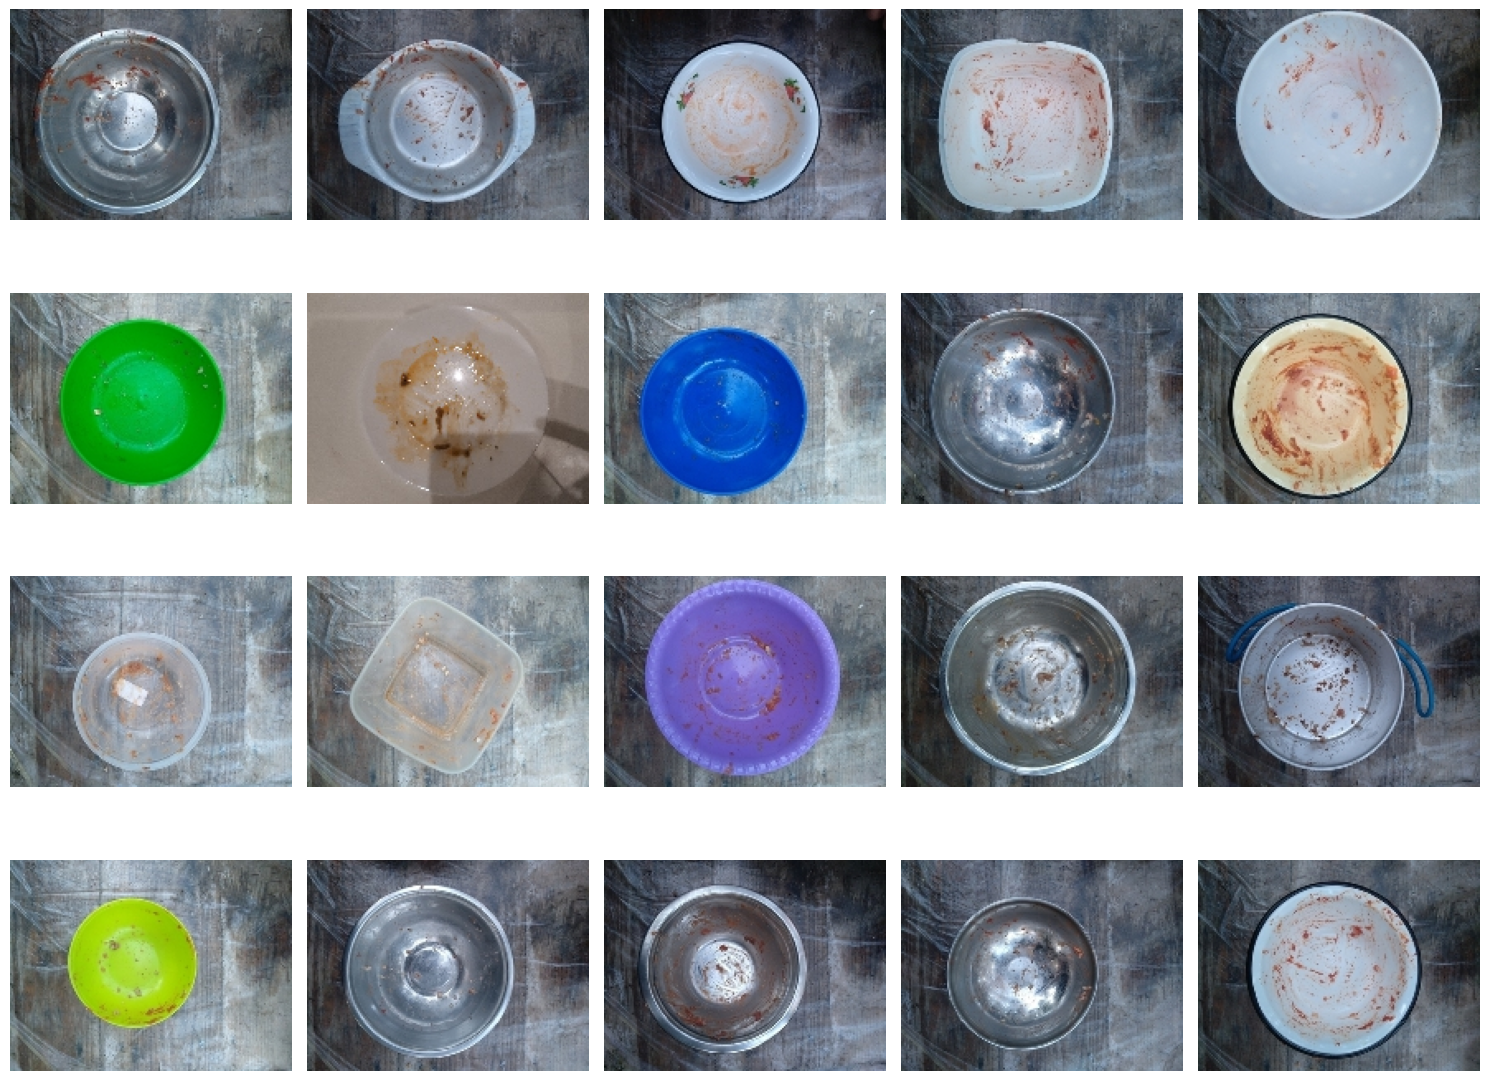

In [29]:
show_some_images(dirty, max_cols=5, thumbnail_size=(128, 128))

In [30]:
def resize_images_to_average(images):
    """
    Resizes a list of image arrays to the average size by cropping or padding.

    Args:
        images (list): List of image matrices (NumPy arrays).

    Returns:
        list: List of resized image matrices.
    """
    # Calculate average dimensions
    avg_height = int(np.mean([img.shape[0] for img in images]))
    avg_width = int(np.mean([img.shape[1] for img in images]))
    target_size = (avg_height, avg_width)
    
    resized_images = []
    for img in images:
        resized_img = resize_image(img, target_size)
        resized_images.append(resized_img)
    
    return resized_images

def resize_image(image, target_size):
    """
    Resizes a single image to target size by cropping or padding.

    Args:
        image (np.ndarray): Image matrix.
        target_size (tuple): Target size as (height, width).

    Returns:
        np.ndarray: Resized image matrix.
    """
    target_height, target_width = target_size
    height, width = image.shape[:2]
    
    # Initialize the new image with zeros (black padding)
    if image.ndim == 3:  # Color image
        resized_image = np.zeros((target_height, target_width, image.shape[2]), dtype=image.dtype)
    else:  # Grayscale image
        resized_image = np.zeros((target_height, target_width), dtype=image.dtype)

    # Calculate cropping or padding indices
    crop_top = max(0, (height - target_height) // 2)
    crop_bottom = min(height, crop_top + target_height)
    crop_left = max(0, (width - target_width) // 2)
    crop_right = min(width, crop_left + target_width)

    pad_top = max(0, (target_height - height) // 2)
    pad_bottom = pad_top + (crop_bottom - crop_top)
    pad_left = max(0, (target_width - width) // 2)
    pad_right = pad_left + (crop_right - crop_left)

    # Copy the cropped portion into the padded target array
    resized_image[pad_top:pad_bottom, pad_left:pad_right] = image[crop_top:crop_bottom, crop_left:crop_right]

    return resized_image


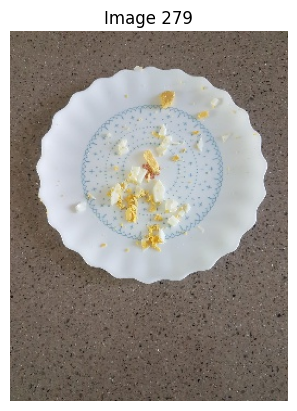

In [31]:
# Example image
show_image(dirty, 279)

In [32]:
resized_data = resize_images_to_average(combined)

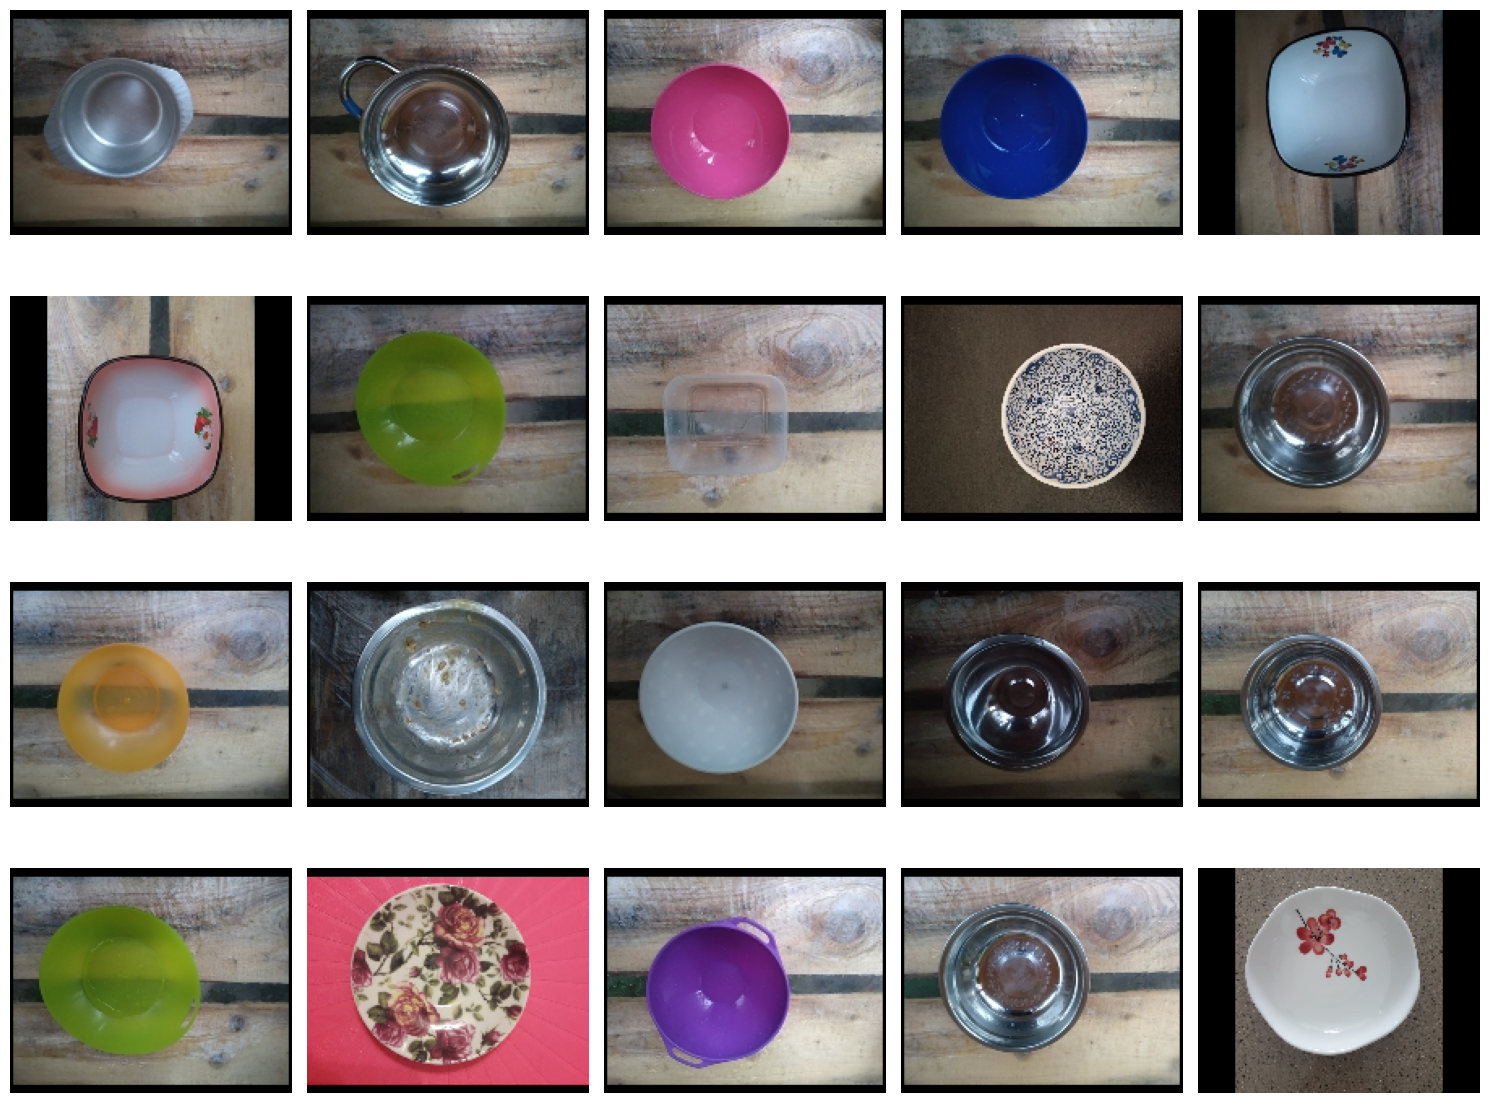

In [33]:
show_some_images(resized_data, max_cols=5, thumbnail_size=(128, 128))

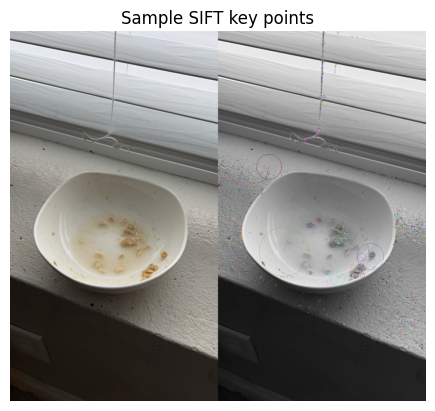

In [34]:
img = cv.imread('data/train/dirty/IMG_2072.JPG')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
 
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
cv.imwrite('data/analysis/sample.jpg',img)
 
img=cv.drawKeypoints(gray,kp,img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
cv.imwrite('data/analysis/sample_SIFT.jpg',img)


# This is only to display the results on the notebook

# Read the images
image1 = mpimg.imread('data/analysis/sample.jpg') 
image2 = mpimg.imread('data/analysis/sample_SIFT.jpg')

# Combine the images horizontally
combined_image = np.hstack((image1, image2))

# Display the combined image
plt.imshow(combined_image)
plt.axis('off')  # Hide axes
plt.title("Sample SIFT key points")
plt.show()

In [35]:
# apply SIFT to every image to get our dataset
# every image transformed: a matrix of pixel values -> a list of 2 lists, keypoints and descriptors
X = []
for image in resized_data:
    kp, des = sift.detectAndCompute(gray, None)
    X.append([kp, des])


In [43]:
def head(lst, n):
    return lst[:n]

def tail(lst, n):
    return lst[-n:]

In [ ]:
print(f"Length of X: {len(X)}")
print(f"Length of X[0]: {len(X[0])}")

num_clean = int(len(clean)) 
num_dirty = int(len(dirty))

# create our y for our data
Y = list(np.zeros(num_clean, dtype=int)) + list(np.ones(num_dirty, dtype=int))

# 0 = clean
# 1 = dirty

# np ints will be casted to native ints when needed

print(f"head(Y): {head(Y, 10)}")
print(f"tail(Y): {tail(Y, 10)}")

Length of X: 792
Length of X[0]: 2
head(Y): [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
tail(Y): [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


In [50]:
# Can't easily pickle the data so must do some of these steps in model train notebook